In [2]:
#importing packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.utils.data as data
import pandas as pd

In [2]:
#data transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

(44, 256, 256)
44


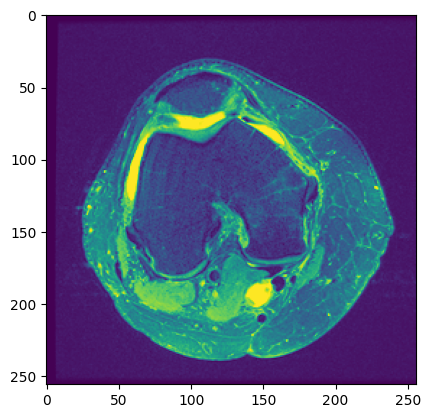

In [10]:
# Shi
# retrieve sample image
input_image = np.load("MRNet-v1.0/train/axial/0000.npy")
print(input_image.shape)
print(str(len(input_image)))
plt.imshow(input_image[int(len(input_image)/2)])

from PIL import Image

im = Image.fromarray(input_image[1])
img = im.convert('RGB')
# img.show()

In [22]:
from itertools import chain
import pandas as pd

def flattenArray(arr): 
    flatten_list = list(chain.from_iterable(arr))
    return flatten_list

#Necessary for file loading
def intToFourDigitStr(n):
    digits = len(str(n))
    if digits == 1:
        return "000" + str(n)
    elif digits == 2:
        return "00" + str(n)
    elif digits == 3:
        return "0" + str(n)
    elif digits == 4:
        return str(n)
    else:
        print("error in intToFourDigitStr")
        return "0000"


numTrain = 1130
numTotal = 1250
numValid = numTotal - numTrain

#build dataset 
xTrain =[]

for i in range (4):
    fileNum = intToFourDigitStr(i)
    axial = np.load("MRNet-v1.0/train/axial/" + fileNum + ".npy")
    coronal = np.load("MRNet-v1.0/train/coronal/" + fileNum + ".npy")
    sagittal = np.load("MRNet-v1.0/train/sagittal/" + fileNum + ".npy")
    middleImageAxial = axial[int(len(axial)/2)]
    middleImageCoronal = coronal[int(len(coronal)/2)]
    middleImageSagittal = sagittal[int(len(sagittal)/2)]
    middleImageAxialFlat = flattenArray(middleImageAxial)
    middleImageCoronalFlat = flattenArray(middleImageCoronal)
    middleImageSagittalFlat = flattenArray(middleImageSagittal)


    row = middleImageAxialFlat
    row.append(middleImageCoronalFlat)
    row.append(middleImageSagittalFlat)
    xTrain.append(row)


xTrainDF = pd.DataFrame(data=xTrain)
print(xTrainDF)
xTrainDF.to_csv("xTrain.csv")


   0      1      2      3      4      5      6      7      8      9      ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   

   65528  65529  65530  65531  65532  65533  65534  65535  \
0      2      3      3      2      2      2      2      2   
1     10      8     11      9      6      9      4      2   
2      1      2      1      2      1      2      2      3   
3     14      7     10      9      9      7      4      2   

                                               65536  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

            

In [19]:
from itertools import chain
import pandas as pd

def flattenArray(arr): 
    flatten_list = list(chain.from_iterable(arr))
    return flatten_list


axial = np.load("MRNet-v1.0/train/axial/0000.npy")
coronal = np.load("MRNet-v1.0/train/coronal/0000.npy")
sagittal = np.load("MRNet-v1.0/train/sagittal/0000.npy")
middleImageAxial = axial[int(len(axial)/2)]
middleImageCoronal = coronal[int(len(coronal)/2)]
middleImageSagittal = sagittal[int(len(sagittal)/2)]
middleImageAxialFlat = flattenArray(middleImageAxial)
middleImageCoronalFlat = flattenArray(middleImageCoronal)
middleImageSagittalFlat = flattenArray(middleImageSagittal)


row = middleImageAxialFlat
row.append(middleImageCoronalFlat)
row.append(middleImageSagittalFlat)


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [4]:
# Shi
# Transform image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)


In [5]:
# Shi
# load resnet18 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

Using cache found in C:\Users\jctub/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\jctub\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jctub\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Shi
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([-2.2522e+00, -6.5522e-01,  1.9629e-01,  2.8600e+00,  3.6164e-01,
         2.7448e+00,  6.6952e-01, -2.3986e+00, -3.8303e+00, -6.7226e-01,
        -3.6155e+00, -4.5776e+00, -3.0640e+00, -4.8245e+00, -8.3618e-01,
        -3.6192e+00, -8.0123e+00, -2.8529e+00,  6.5950e-01, -3.2586e+00,
        -3.7077e+00, -8.2626e+00, -5.0530e+00, -5.1124e+00, -4.7201e+00,
         1.0792e+00, -1.1661e+00, -2.1520e+00,  2.5623e+00, -2.1108e+00,
         1.5578e+00,  3.6488e+00,  3.8152e+00,  1.6522e+00,  4.2716e-01,
        -1.2033e+00,  1.1237e+00, -4.0514e-01, -2.5158e-01, -3.0838e+00,
        -1.7823e+00, -3.9357e+00, -3.3397e+00, -4.1002e+00, -2.0601e+00,
        -2.3863e+00, -2.8950e+00, -5.0099e+00, -3.8962e+00, -2.1764e+00,
        -1.3137e+00,  2.8802e+00,  7.2483e-01,  2.4773e+00,  2.8460e+00,
        -9.5255e-01,  2.4130e+00, -9.2152e-01, -3.7419e-01,  2.0040e+00,
         5.7249e+00,  5.5663e+00,  1.9847e+00, -6.6522e-01, -8.8638e-01,
         3.7350e+00,  3.1616e+00,  1.3887e+00,  2.3

In [7]:
class MRDataset(data.Dataset):
    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])
        label = self.labels[index]
        label = torch.FloatTensor([label])

        if self.transform:
            array = self.transform(array)
        else:
            array = np.stack((array,)*3, axis=1)
            array = torch.FloatTensor(array)

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight

In [8]:
k = MRDataset('MRNet-v1.0/', 'acl', 'axial')

In [9]:
k.__getitem__(0)

(tensor([[[[ 0.,  0.,  0.,  ...,  5.,  4.,  3.],
           [ 0.,  0.,  0.,  ...,  8.,  6.,  8.],
           [ 0.,  0.,  0.,  ..., 14., 11., 11.],
           ...,
           [ 0.,  0.,  0.,  ..., 16., 15., 12.],
           [ 0.,  0.,  0.,  ..., 12., 13., 12.],
           [ 0.,  0.,  0.,  ..., 11.,  7.,  9.]],
 
          [[ 0.,  0.,  0.,  ...,  5.,  4.,  3.],
           [ 0.,  0.,  0.,  ...,  8.,  6.,  8.],
           [ 0.,  0.,  0.,  ..., 14., 11., 11.],
           ...,
           [ 0.,  0.,  0.,  ..., 16., 15., 12.],
           [ 0.,  0.,  0.,  ..., 12., 13., 12.],
           [ 0.,  0.,  0.,  ..., 11.,  7.,  9.]],
 
          [[ 0.,  0.,  0.,  ...,  5.,  4.,  3.],
           [ 0.,  0.,  0.,  ...,  8.,  6.,  8.],
           [ 0.,  0.,  0.,  ..., 14., 11., 11.],
           ...,
           [ 0.,  0.,  0.,  ..., 16., 15., 12.],
           [ 0.,  0.,  0.,  ..., 12., 13., 12.],
           [ 0.,  0.,  0.,  ..., 11.,  7.,  9.]]],
 
 
         [[[ 0.,  0.,  0.,  ...,  3.,  2.,  2.],
         